This run has higher dropout, smaller size lstm.

This run has validation accuracy around 60%

From results shown, high dropout does contribute to regularization, but smaller size lstm decrease the ability to fit in more features. Should try larger size lstm next time.

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Activation, Flatten
from keras.utils import to_categorical
import numpy as np
import h5py
import matplotlib.pyplot as plt
from data_utils import get_data
from sklearn import preprocessing


In [8]:
# Load data from all .mat files, combine them, eliminate EOG signals, shuffle and 
# seperate training data, validation data and testing data.
# Also do mean subtraction on x.

data = get_data('../project_datasets',num_validation=100, num_test=0, subtract_mean=True, subtract_axis=1,
                transpose=True)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (2458, 1000, 22) 
y_train: (2458,) 
X_val: (100, 1000, 22) 
y_val: (100,) 
X_test: (0, 1000, 22) 
y_test: (0,) 


In [9]:
num_classes = 4

# substract data from list
X_train = data.get('X_train')
y_train = data.get('y_train')
X_val = data.get('X_val')
y_val = data.get('y_val')

# get data dimension
N_train, T_train, C_train = data.get('X_train').shape
N_val, T_val, C_val = data.get('X_val').shape

# add dummy zeros for y classification, convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

In [10]:
# construct X_total and y_total based on sub-sampling of X_train and y_train

# take sub-sampling on the time sequence to reduce dimension for RNN
sampling = 1

X_train = X_train.reshape(N_train,int(T_train/sampling), sampling, C_train)[:,:,0,:]
X_val = X_val.reshape(N_val,int(T_val/sampling), sampling, C_val)[:,:,0,:]
    
# get new data dimension
N_train, T_train, C_train = X_train.shape
N_val, T_val, C_val = X_val.shape

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)

X_train:  (2458, 1000, 22)
y_train:  (2458, 4)
X_val:  (100, 1000, 22)
y_val:  (100, 4)


In [11]:
# Expected input batch shape: (batch_size, timesteps, data_dim)
# Note that we have to provide the full batch_input_shape since the network is stateful.
# the sample of index i in batch k is the follow-up for the sample i in batch k-1.

# perhaps should try masking layer

data_dim = C_train
timesteps = T_train
batch_size = 100
num_epoch = 100

# make a sequential model
model = Sequential()

# add 1-layer cnn
model.add(Conv1D(40, kernel_size=12, strides=4,
          input_shape=(timesteps, data_dim)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4, strides=4))


# add 2-layer lstm
model.add(LSTM(10, return_sequences=True, stateful=False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(10, return_sequences=True, stateful=False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# set loss function and optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
# train the data with validation
history = model.fit(X_train, y_train,
                    batch_size=batch_size, 
                    epochs=num_epoch, 
                    shuffle=False,
                    validation_data=(X_val, y_val))

Train on 2458 samples, validate on 100 samples
Epoch 1/100
2458/2458 [==============================] - 6s 2ms/step - loss: 1.9310 - acc: 0.2648 - val_loss: 1.4709 - val_acc: 0.3000
Epoch 2/100
2458/2458 [==============================] - 4s 2ms/step - loss: 1.7403 - acc: 0.2640 - val_loss: 1.3668 - val_acc: 0.3400
Epoch 3/100
2458/2458 [==============================] - 4s 2ms/step - loss: 1.6307 - acc: 0.2909 - val_loss: 1.3249 - val_acc: 0.3600
Epoch 4/100
2458/2458 [==============================] - 4s 2ms/step - loss: 1.5410 - acc: 0.3153 - val_loss: 1.3210 - val_acc: 0.3600
Epoch 5/100
2458/2458 [==============================] - 4s 2ms/step - loss: 1.4834 - acc: 0.3336 - val_loss: 1.2955 - val_acc: 0.4200
Epoch 6/100
2458/2458 [==============================] - 4s 2ms/step - loss: 1.4551 - acc: 0.3438 - val_loss: 1.3139 - val_acc: 0.3800
Epoch 7/100
2458/2458 [==============================] - 4s 2ms/step - loss: 1.4301 - acc: 0.3332 - val_loss: 1.3266 - val_acc: 0.4300
Epoch 8/

Epoch 61/100
2458/2458 [==============================] - 4s 2ms/step - loss: 0.8588 - acc: 0.6530 - val_loss: 0.9421 - val_acc: 0.6000
Epoch 62/100
2458/2458 [==============================] - 4s 2ms/step - loss: 0.8633 - acc: 0.6558 - val_loss: 0.9202 - val_acc: 0.6000
Epoch 63/100
2458/2458 [==============================] - 4s 2ms/step - loss: 0.8204 - acc: 0.6725 - val_loss: 0.9425 - val_acc: 0.6000
Epoch 64/100
2458/2458 [==============================] - 4s 2ms/step - loss: 0.8186 - acc: 0.6729 - val_loss: 0.9586 - val_acc: 0.5500
Epoch 65/100
2458/2458 [==============================] - 4s 2ms/step - loss: 0.8138 - acc: 0.6697 - val_loss: 0.9140 - val_acc: 0.6400
Epoch 66/100
2458/2458 [==============================] - 5s 2ms/step - loss: 0.8484 - acc: 0.6550 - val_loss: 0.9527 - val_acc: 0.5700
Epoch 67/100
2458/2458 [==============================] - 4s 2ms/step - loss: 0.8527 - acc: 0.6505 - val_loss: 0.9646 - val_acc: 0.6300
Epoch 68/100
2458/2458 [========================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


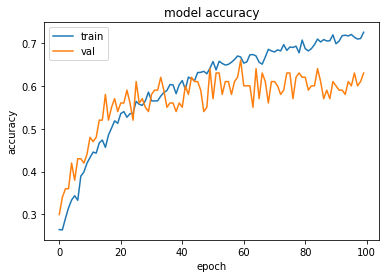

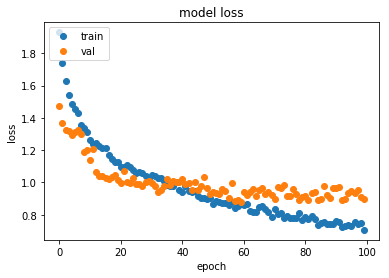

In [13]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()